# Import Packages and load dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import rand
import pandas as pd
import os
import seaborn as sns

import missingno as msno

from sklearn.experimental import enable_iterative_imputer   # enabling the experimental IterativeImputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import OrdinalEncoder

import statsmodels.api as sm

from fancyimpute import KNN

%matplotlib inline

In [2]:
''' data directories '''

datadir = '../datasets/raw'
datadir_pr = '../datasets/processed'

In [3]:
diabetes = pd.read_csv(os.path.join(datadir,'pima-indians-diabetes data.csv'))
airquality = pd.read_csv(os.path.join(datadir,'air-quality.csv'), parse_dates=['Date'], index_col='Date')

In [4]:
college = pd.read_csv(os.path.join(datadir_pr,'college.csv'), index_col=0)
users   = pd.read_csv(os.path.join(datadir_pr,'users_category.csv'), index_col=0)

# Problem w/ Missing Data

In [5]:
college.head()

,gradrat,lenroll,rmbrd,private,stufac,csat,act
0,59.0,5.1761497326,3.75,1.0,10.8,.,21.0
1,52.0,4.7791234931,3.74,1.0,17.7,.,21.0
2,75.0,6.122492809500001,.,1.0,11.4,1052.0,24.0
3,56.0,5.3181199938,4.1,1.0,11.6,940.0,23.0
4,71.0,5.631211781799999,.,1.0,18.3,.,17.0


In [6]:
college.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gradrat  200 non-null    object 
 1   lenroll  200 non-null    object 
 2   rmbrd    200 non-null    object 
 3   private  200 non-null    float64
 4   stufac   200 non-null    object 
 5   csat     200 non-null    object 
 6   act      200 non-null    object 
dtypes: float64(1), object(6)
memory usage: 12.5+ KB


In [7]:
csat_unique = college.csat.unique()
print(np.sort(csat_unique))

['.' '1000.0' '1006.0' '1010.0' '1013.0' '1020.0' '1024.0' '1026.0'
 '1028.0' '1036.0' '1039.0' '1040.0' '1044.0' '1045.0' '1050.0' '1052.0'
 '1060.0' '1070.0' '1080.0' '1092.0' '1096.0' '1109.0' '1111.0' '1120.0'
 '1139.0' '1150.0' '1171.0' '1200.0' '1210.0' '1220.0' '1230.0' '1270.0'
 '1292.0' '1324.0' '1381.0' '741.0' '763.0' '764.0' '782.0' '800.0'
 '802.0' '810.0' '813.0' '814.0' '816.0' '825.0' '830.0' '832.0' '837.0'
 '843.0' '846.0' '850.0' '853.0' '854.0' '860.0' '863.0' '867.0' '871.0'
 '880.0' '881.0' '885.0' '890.0' '891.0' '895.0' '897.0' '900.0' '902.0'
 '905.0' '911.0' '917.0' '919.0' '923.0' '937.0' '940.0' '943.0' '947.0'
 '950.0' '951.0' '964.0' '970.0' '979.0' '980.0' '989.0' '992.0' '994.0'
 '996.0' '997.0' '998.0']


> by checking sorted value, we can find the non-numeric value in the column

## Replacing missing values when it reads the data

In [8]:
# Read the dataset 'college.csv' with na_values set to '.'
college = pd.read_csv(os.path.join(datadir_pr, 'college.csv'), na_values='.', index_col=0)
print(college.head())

# Print the info of college
print(college.info())

   gradrat   lenroll  rmbrd  private  stufac    csat   act
0     59.0  5.176150   3.75      1.0    10.8     NaN  21.0
1     52.0  4.779123   3.74      1.0    17.7     NaN  21.0
2     75.0  6.122493    NaN      1.0    11.4  1052.0  24.0
3     56.0  5.318120   4.10      1.0    11.6   940.0  23.0
4     71.0  5.631212    NaN      1.0    18.3     NaN  17.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gradrat  187 non-null    float64
 1   lenroll  199 non-null    float64
 2   rmbrd    114 non-null    float64
 3   private  200 non-null    float64
 4   stufac   199 non-null    float64
 5   csat     105 non-null    float64
 6   act      104 non-null    float64
dtypes: float64(7)
memory usage: 12.5 KB
None


> See the dtype is now float not object

## Repalcing Hidden Missing Values

In [9]:
''' pre-process the data for the example (finding hidden missing values) '''
diabetes.loc[diabetes.BMI.isnull(), 'BMI'] = 0.

In [10]:
diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnant,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,763.0,121.686763,30.535641,44.000,99.00000,117.0000,141.00000,199.00
Diastolic_BP,733.0,72.405184,12.382158,24.000,64.00000,72.0000,80.00000,122.00
Skin_Fold,541.0,29.153420,10.476982,7.000,22.00000,29.0000,36.00000,99.00
Serum_Insulin,394.0,155.548223,118.775855,14.000,76.25000,125.0000,190.00000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
Diabetes_Pedigree,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Class,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


> `BMI` has a minimum value of zero, which is not expected.

In [11]:
# Store all rows of column 'BMI' which are equal to 0 
diabetes.BMI[diabetes.BMI == 0]

9      0.0
49     0.0
60     0.0
81     0.0
145    0.0
371    0.0
426    0.0
494    0.0
522    0.0
684    0.0
706    0.0
Name: BMI, dtype: float64

In [12]:
# Set the 0 values of column 'BMI' to np.nan
diabetes.loc[diabetes.BMI == 0, 'BMI'] = np.nan

# Print the 'NaN' values in the column BMI
diabetes.BMI[diabetes.BMI.isnull()]

9     NaN
49    NaN
60    NaN
81    NaN
145   NaN
371   NaN
426   NaN
494   NaN
522   NaN
684   NaN
706   NaN
Name: BMI, dtype: float64

## Missingness Percentage

In [13]:
airquality.head()

,Ozone,Solar,Wind,Temp
Date,,,,
1976-05-01,41.0,190.0,7.4,67
1976-05-02,36.0,118.0,8.0,72
1976-05-03,12.0,149.0,12.6,74
1976-05-04,18.0,313.0,11.5,62
1976-05-05,NaN,NaN,14.3,56


In [14]:
# Create a nullity DataFrame airquality_nullity
airquality_nullity = airquality.isnull()
print(airquality_nullity.head())
print("="*50)

# Calculate total of missing values
missing_values_sum = airquality_nullity.sum()
print('Total Missing Values:\n', missing_values_sum)
print("="*50)

# Calculate percentage of missing values
missing_values_percent = airquality_nullity.mean() * 100
print('Percentage of Missing Values:\n', missing_values_percent)

            Ozone  Solar   Wind   Temp
Date                                  
1976-05-01  False  False  False  False
1976-05-02  False  False  False  False
1976-05-03  False  False  False  False
1976-05-04  False  False  False  False
1976-05-05   True   True  False  False
Total Missing Values:
 Ozone    37
Solar     7
Wind      0
Temp      0
dtype: int64
Percentage of Missing Values:
 Ozone    24.183007
Solar     4.575163
Wind      0.000000
Temp      0.000000
dtype: float64


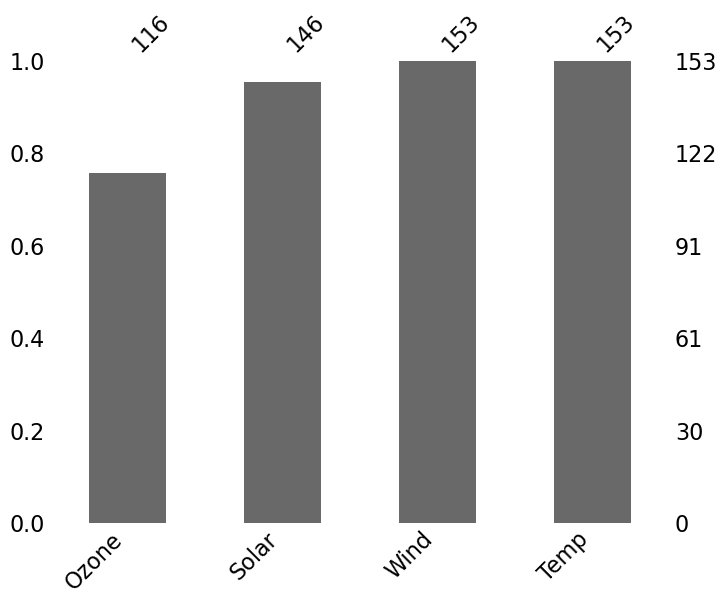

In [15]:
# Plot amount of missingness
msno.bar(airquality, figsize=(8,6));

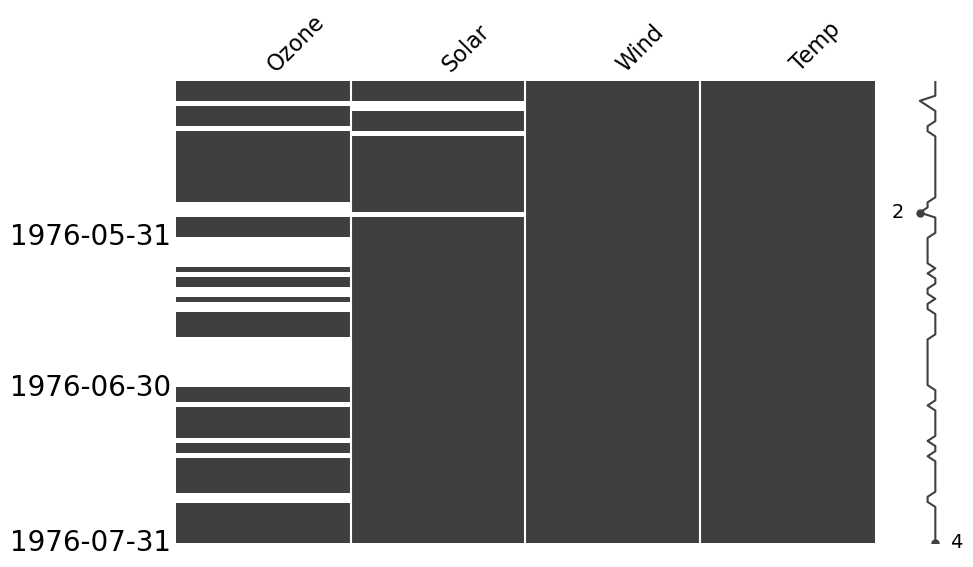

In [16]:
# Plot the sliced nullity matrix of airquality with frequency 'M'
msno.matrix(airquality.loc['May-1976':'Jul-1976'], freq='M', figsize=(10,6));

# Does Missingness Have a Pattern?

**Missingness types**
- Missing Completely at Random (MCAR)
- Missing at Random (MAR)
- Missing Not at Random (MNAR)

## Guess the Missingness types

In [17]:
diabetes.head()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
0,6.0,148.0,72.0,35.0,NaN,33.6,0.627,50,1.0
1,1.0,85.0,66.0,29.0,NaN,26.6,0.351,31,0.0
2,8.0,183.0,64.0,NaN,NaN,23.3,0.672,32,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1.0


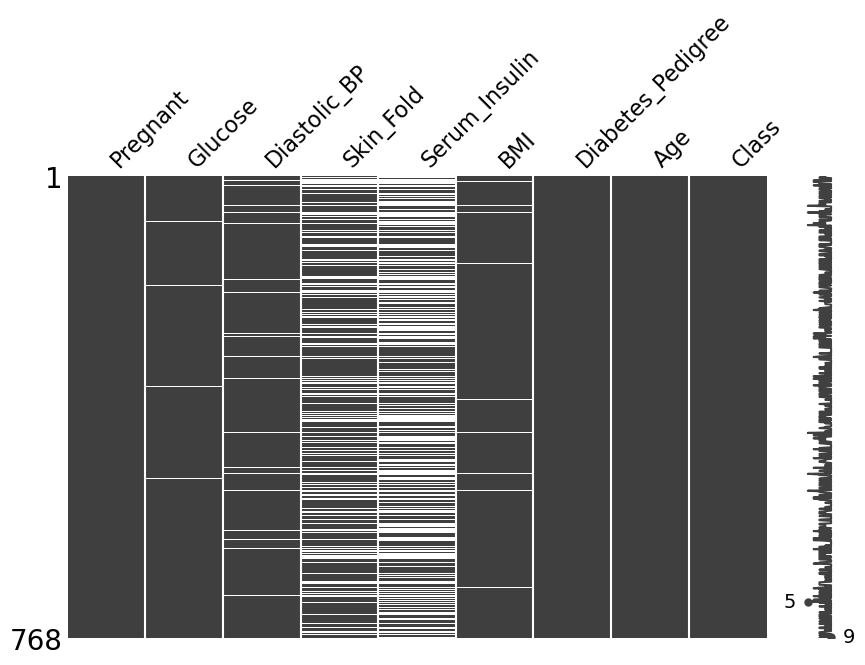

In [18]:
# Visualize the missingness summary
msno.matrix(diabetes, figsize=(10,6));

> - `BMI` is missing completely at random 
> - `Diastolic_BP` is missing at random

## spree to affirmatively identify data that is Missing Not at Random (MNAR)

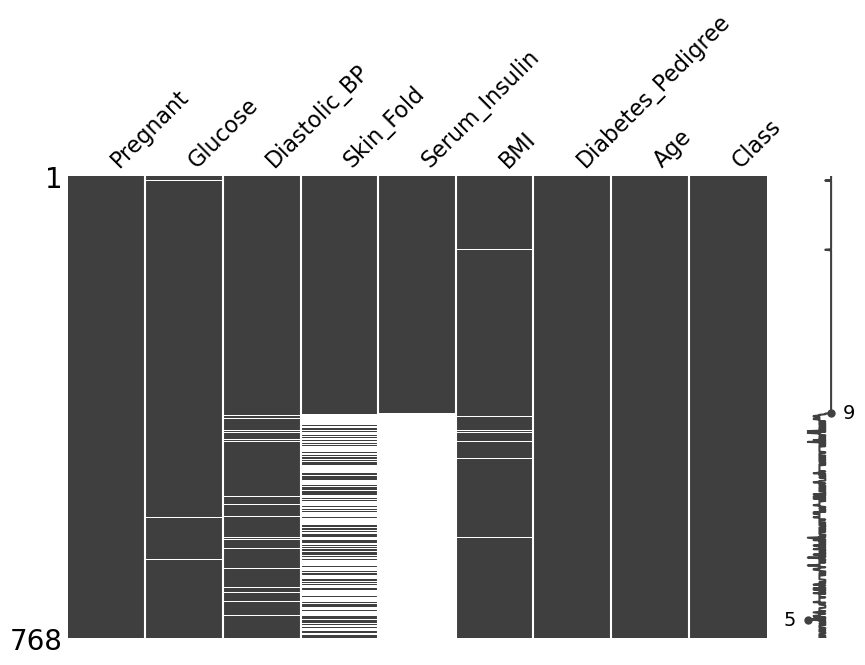

In [19]:
# Sort diabetes dataframe on 'Serum Insulin'
sorted_values = diabetes.sort_values('Serum_Insulin')

# Visualize the missingness summary of sorted
msno.matrix(sorted_values, figsize=(10,6));

## Findign Correlation in the missing data

- Finding correlations between missing data

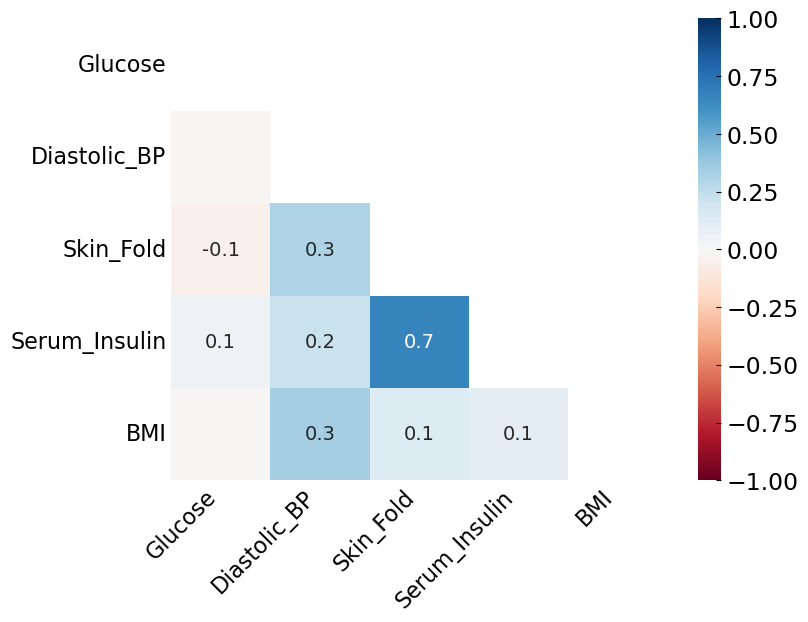

In [20]:
# Plot missingness heatmap of diabetes
msno.heatmap(diabetes, figsize=(8,6));

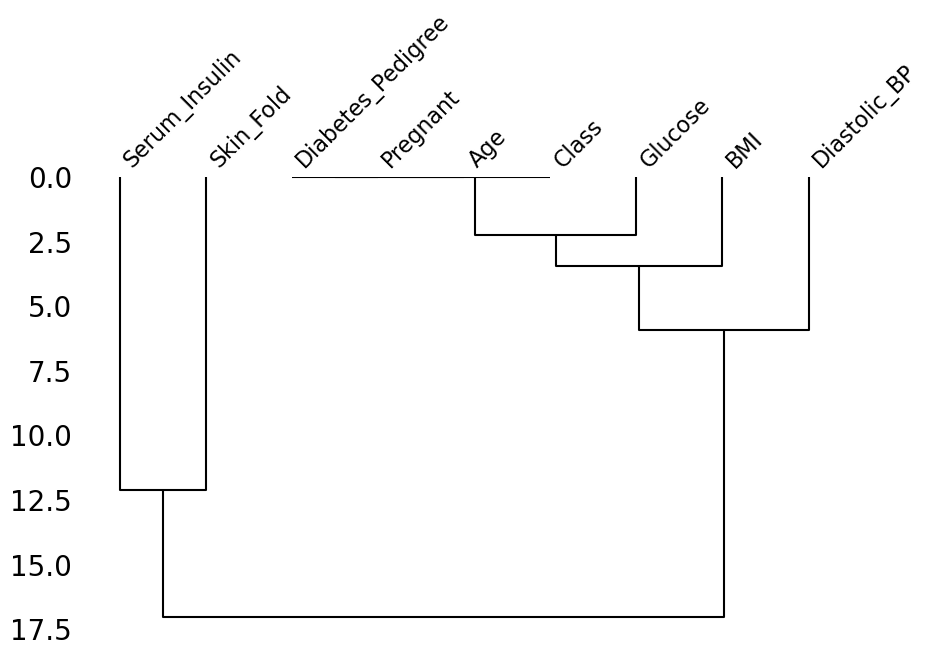

In [21]:
# Plot missingness dendrogram of diabetes
msno.dendrogram(diabetes, figsize=(10,6));

## Fill dummy values

In [22]:
''' Fill the null values with the random values within the scaled range '''

def fill_dummy_values(df, scaling_factor=0.075):
    
    df_dummy = df.copy(deep=True)
    
    for col_name in df_dummy:
        
        col = df_dummy[col_name]
        col_null = col.isnull()
        
        # Calculate number of missing values in column 
        num_nulls = col_null.sum()
        
        # Calculate column range
        col_range = col.max() - col.min()
        
        # generate random values , and subtract 2 to shift it to below the data (rand: 0-1)
        # Scale the random values to scaling_factor times col_range
        dummy_values = (rand(num_nulls) - 2) * scaling_factor * col_range + col.min()
        
        #col[col_null] = dummy_values
        df_dummy.loc[col_null, col_name] = dummy_values
    return df_dummy

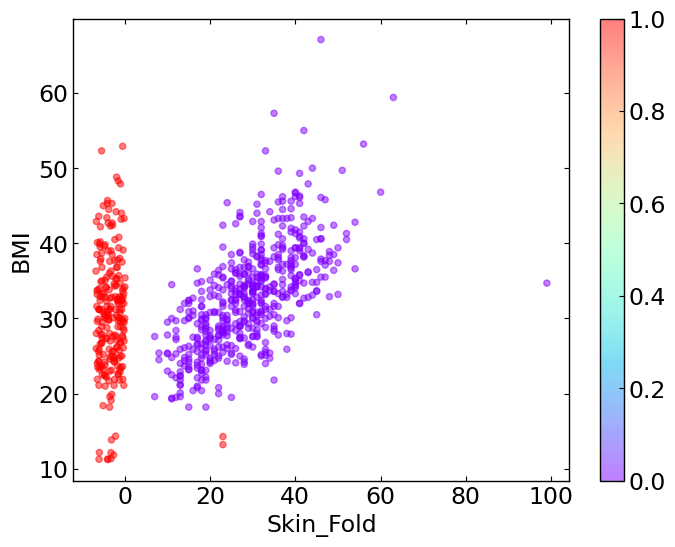

In [23]:
# Fill dummy values in diabetes_dummy
diabetes_dummy = fill_dummy_values(diabetes)

# Sum the nullity of Skin_Fold and BMI
nullity = diabetes.Skin_Fold.isnull() + diabetes.BMI.isnull()

# Create a scatter plot of Skin Fold and BMI
# Set color to nullity of BMI and Skin_Fold
ax = diabetes_dummy.plot(x='Skin_Fold', y='BMI', kind='scatter', alpha=0.5, c=nullity, cmap='rainbow');

In [24]:
nullity

0      False
1      False
2       True
3      False
4      False
       ...  
763    False
764    False
765    False
766     True
767    False
Length: 768, dtype: bool

## Delete MCAR

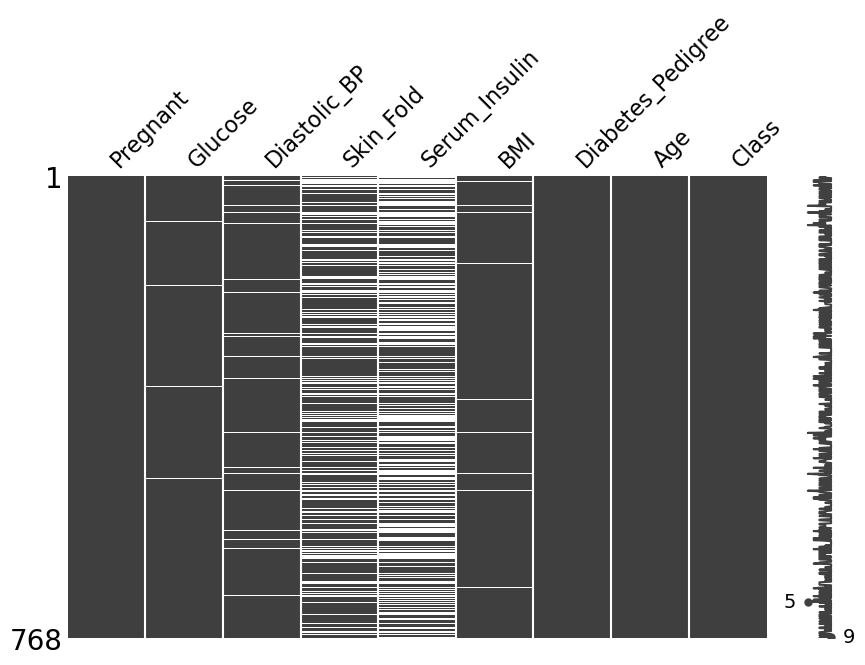

In [25]:
msno.matrix(diabetes, figsize=(10,6));

5


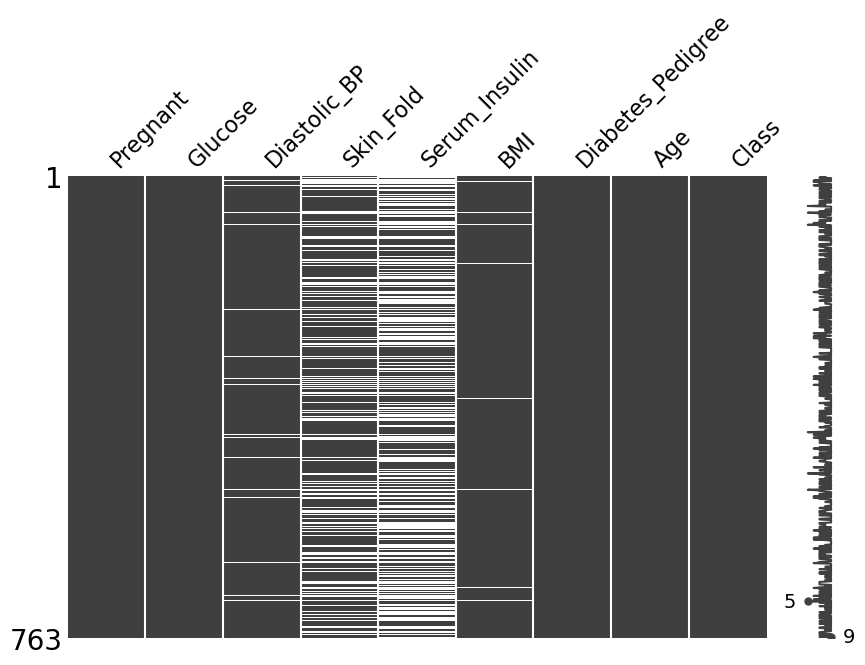

In [26]:
# Print the number of missing values in Glucose
print(diabetes['Glucose'].isnull().sum())

# Drop rows where 'Glucose' has a missing value
diabetes.dropna(subset=['Glucose'], how='any', inplace=True)

# Visualize the missingness of diabetes after dropping missing values
msno.matrix(diabetes, figsize=(10,6));

# Imputation Techniques

- mean / median
- mode / constant

In [27]:
''' mean Imputer '''

# Make a copy of diabetes
diabetes_mean = diabetes.copy(deep=True)

# Create mean imputer object
mean_imputer = SimpleImputer(strategy='mean')

# Impute mean values in the DataFrame diabetes_mean
diabetes_mean.iloc[:, :] = mean_imputer.fit_transform(diabetes_mean)

In [28]:
''' median Imputer '''

# Make a copy of diabetes
diabetes_median = diabetes.copy(deep=True)

# Create median imputer object
median_imputer = SimpleImputer(strategy='median')

# Impute median values in the DataFrame diabetes_median
diabetes_median.iloc[:, :] = median_imputer.fit_transform(diabetes_median)

In [29]:
''' mode (most frequent) Imputer '''

# Make a copy of diabetes
diabetes_mode = diabetes.copy(deep=True)

# Create mode imputer object
mode_imputer = SimpleImputer(strategy='most_frequent')

# Impute using most frequent value in the DataFrame mode_imputer
diabetes_mode.iloc[:, :] = mode_imputer.fit_transform(diabetes_mode)

In [30]:
''' Constant Imputer '''

# Make a copy of diabetes
diabetes_constant = diabetes.copy(deep=True)

# Create constant imputer object -> fill_value
constant_imputer = SimpleImputer(strategy='constant', fill_value=0)

# Impute missing values to 0 in diabetes_constant
diabetes_constant.iloc[:, :] = constant_imputer.fit_transform(diabetes_constant)

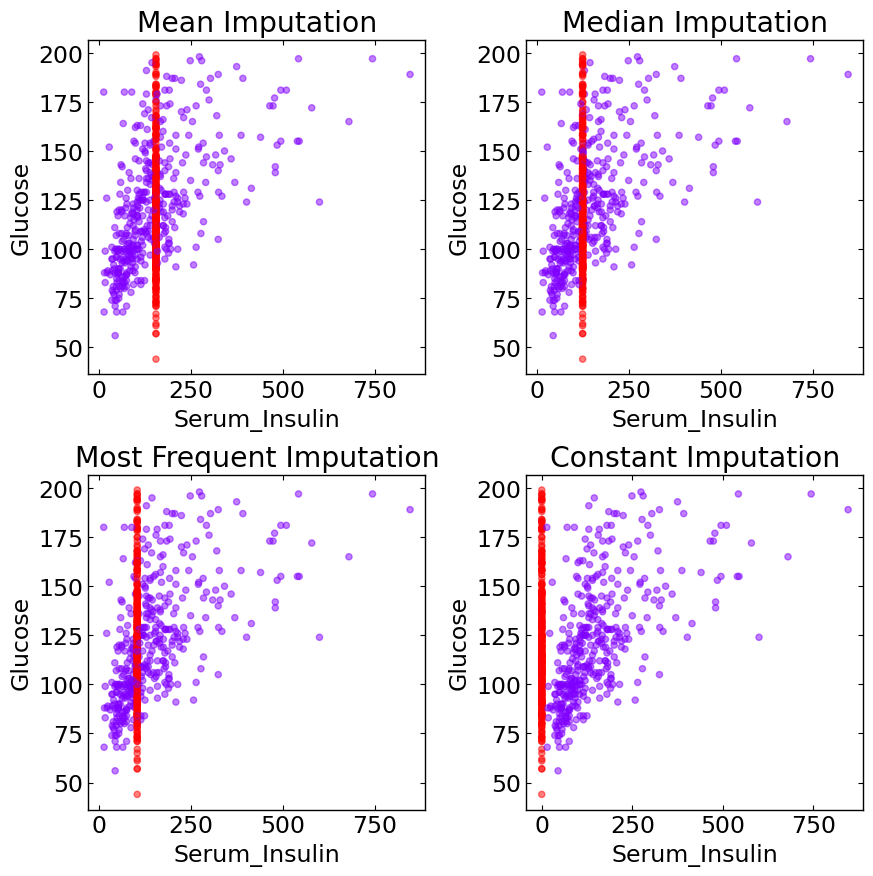

In [31]:
''' Visualize Imputations '''

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
nullity = diabetes.Serum_Insulin.isnull() + diabetes.Glucose.isnull()  # True when at least one of feature is null.

# Create a dictionary of imputations
imputations = {'Mean Imputation': diabetes_mean, 'Median Imputation': diabetes_median, 
               'Most Frequent Imputation': diabetes_mode, 'Constant Imputation': diabetes_constant}

# Loop over flattened axes and imputations
for ax, df_key in zip(axes.flatten(), imputations):
    # Select and also set the title for a DataFrame
    imputations[df_key].plot(x='Serum_Insulin', y='Glucose', kind='scatter', 
                          alpha=0.5, c=nullity, cmap='rainbow', ax=ax, 
                          colorbar=False, title=df_key)
    
fig.subplots_adjust(hspace=0.3, wspace=0.3);

## Imputing Time-series data

- .fillna() method
    - ffill or pad
    - bfill or backwardfill
- .interpolate() method
    - linear
    - quadratic
    - nearest (between ffill and bfill)

In [32]:
# Impute airquality DataFrame with ffill method
ffill_imputed = airquality.fillna(method='ffill').copy()

# Impute airquality DataFrame with bfill method
bfill_imputed = airquality.fillna(method='bfill').copy()

# Interpolate the NaNs linearly
linear_imputed = airquality.interpolate(method='linear').copy()

# Interpolate the NaNs quadratically
quadratic_imputed = airquality.interpolate(method='quadratic').copy()

# Interpolate the NaNs with nearest value
nearest_imputed = airquality.interpolate(method='nearest').copy()

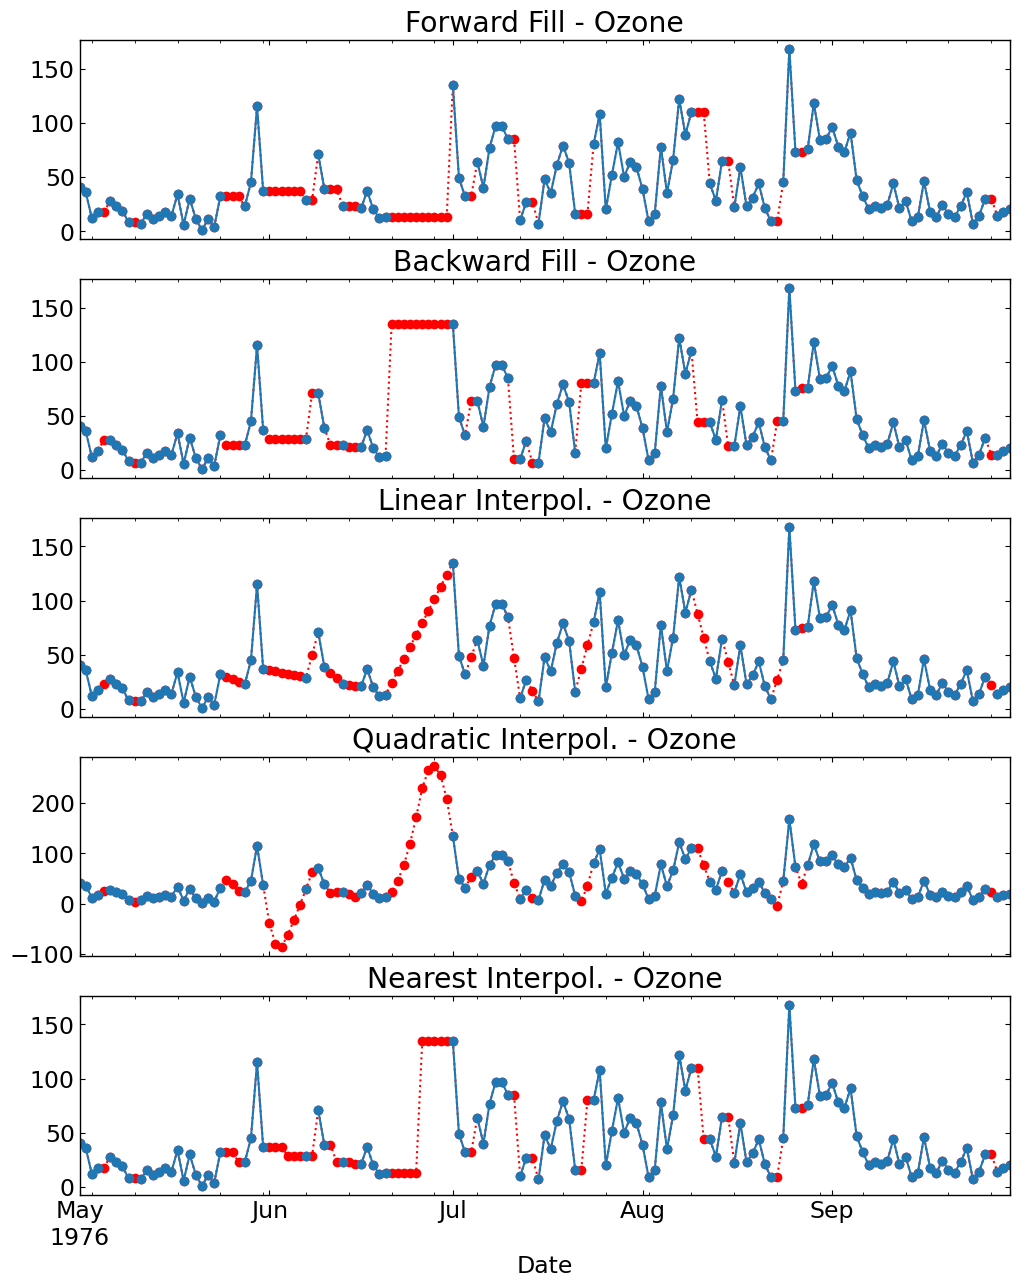

In [33]:
''' Visualization of impute '''

fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

# Create a dictionary of imputers

imputes = {'Forward Fill':ffill_imputed, 'Backward Fill':bfill_imputed, 'Linear Interpol.':linear_imputed, \
           'Quadratic Interpol.':quadratic_imputed, 'Nearest Interpol.':nearest_imputed}

# Loop over axes and interpolations
for ax, df_key in zip(axes.flatten(), imputes):
  # Select and also set the title for a DataFrame
  imputes[df_key].Ozone.plot(color='red', marker='o', 
                                 linestyle='dotted', ax=ax)
  airquality.Ozone.plot(title=df_key + ' - Ozone', marker='o', ax=ax)

> Quadratic has overshoot points -> not good. 

# Advanced Imputation Techniques

- Fancy Imputer package
    - K-Nearest Neighbor (KNN)
- Scikit-learn package
    - IterativeImputer: Multiple Imputation by Chained Equations (MICE)

In [34]:
# Copy diabetes to diabetes_knn_imputed
diabetes_knn_imputed = diabetes.copy(deep=True)

# Initialize KNN
knn_imputer = KNN()

# Impute using fit_tranform on diabetes_knn_imputed
diabetes_knn_imputed.iloc[:, :] = knn_imputer.fit_transform(diabetes_knn_imputed)

Imputing row 1/763 with 1 missing, elapsed time: 0.081
Imputing row 101/763 with 2 missing, elapsed time: 0.083
Imputing row 201/763 with 1 missing, elapsed time: 0.085
Imputing row 301/763 with 0 missing, elapsed time: 0.087
Imputing row 401/763 with 2 missing, elapsed time: 0.089
Imputing row 501/763 with 2 missing, elapsed time: 0.091
Imputing row 601/763 with 1 missing, elapsed time: 0.093
Imputing row 701/763 with 1 missing, elapsed time: 0.095


In [35]:
# Copy diabetes to diabetes_mice_imputed
diabetes_mice_imputed = diabetes.copy(deep=True)

# Initialize IterativeImputer
mice_imputer = IterativeImputer()

# Impute using fit_tranform on diabetes
diabetes_mice_imputed.iloc[:, :] = mice_imputer.fit_transform(diabetes)

## Imputing Categorical values

- Imputing after converting categorical values to numeric by one-hot or ordinal methods

In [36]:
users.head()

,smoker,drink_level,dress_preference,ambience,hijos,activity,budget
0,False,abstemious,informal,family,independent,student,medium
1,False,abstemious,informal,family,independent,student,low
2,False,social drinker,formal,family,independent,student,low
3,False,abstemious,informal,family,independent,professional,medium
4,False,abstemious,no preference,family,independent,student,medium


In [37]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 137
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   smoker            135 non-null    object
 1   drink_level       138 non-null    object
 2   dress_preference  133 non-null    object
 3   ambience          132 non-null    object
 4   hijos             127 non-null    object
 5   activity          131 non-null    object
 6   budget            131 non-null    object
dtypes: object(7)
memory usage: 8.6+ KB


### Ordinal Encoding of a DataFrame

In [38]:
# Create an empty dictionary ordinal_enc_dict
ordinal_enc_dict = {}

for col_name in users:
    # Create Ordinal encoder for col
    ordinal_enc_dict[col_name] = OrdinalEncoder()
    col = users[col_name]
    
    # Select non-null values of col
    col_not_null = col[col.notnull()]
    reshaped_vals = col_not_null.values.reshape(-1, 1)
    encoded_vals = ordinal_enc_dict[col_name].fit_transform(reshaped_vals)
    
    # Store the values to non-null values of the column in users
    users.loc[col.notnull(), col_name] = np.squeeze(encoded_vals)

### KNN Imputation of categorical values

In [39]:
# Create KNN imputer
KNN_imputer = KNN()

# Impute and round the users DataFrame
users.iloc[:, :] = np.round(KNN_imputer.fit_transform(users))

# Loop over the column names in users
for col_name in users:
    
    # Reshape the data
    reshaped = users[col_name].values.reshape(-1, 1)
    
    # Perform inverse transform of the ordinally encoded columns
    users[col_name] = ordinal_enc_dict[col_name].inverse_transform(reshaped)

Imputing row 1/138 with 0 missing, elapsed time: 0.008
Imputing row 101/138 with 0 missing, elapsed time: 0.010


## Evaluation of different imputation techniques

For analysis, you can fit a linear regression model on the imputed DataFrame and check for various parameters that impact the selection of the imputation type.

In [40]:
diabetes.head()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
0,6.0,148.0,72.0,35.0,NaN,33.6,0.627,50,1.0
1,1.0,85.0,66.0,29.0,NaN,26.6,0.351,31,0.0
2,8.0,183.0,64.0,NaN,NaN,23.3,0.672,32,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1.0


In [41]:
''' Complete case (drop all null values) '''
diabetes_cc = diabetes.dropna().copy(deep=True)

# Add constant to X and set X & y values to fit linear model
X = sm.add_constant(diabetes_cc.iloc[:, :-1])
y = diabetes_cc['Class']
lm = sm.OLS(y, X).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Class   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     25.30
Date:                Sun, 04 Sep 2022   Prob (F-statistic):           2.65e-31
Time:                        01:16:11   Log-Likelihood:                -177.76
No. Observations:                 392   AIC:                             373.5
Df Residuals:                     383   BIC:                             409.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.1027      0.144     -7.681      0.000      -1.385      -0.820
Pregnant              0.0130      0.008      1.549      0.122      -0.003       0.029
Glucose               0.0064      0.001      7.855      0.000       0.005       0.008
Diastolic_BP       5.465e-05      0.002      0.032      0.975      -0.003       0.003
Skin_Fold             0.0017      0.003      0.665      0.506      -0.003       0.007
Serum_Insulin        -0.0001      0.000     -0.603      0.547      -0.001       0.000
BMI                   0.0093      0.004      2.391      0.017       0.002       0.017
Diabetes_Pedigree     0.1572      0.058      2.708      0.007       0.043       0.271
Age                   0.0059      0.003      2.109      0.036       0.000       0.011
==============================================================================
Omnibus:                        9.511   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.387
Skew:                           0.344   Prob(JB):                      0.00916
Kurtosis:                       2.682   Cond. No.                     1.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
''' filled by mean '''

# Add constant to X and set X & y values to fit linear model
X = sm.add_constant(diabetes_mean.iloc[:, :-1])
y = diabetes_mean['Class']
lm_mean = sm.OLS(y, X).fit()

lm_mean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Class   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     44.28
Date:                Sun, 04 Sep 2022   Prob (F-statistic):           2.63e-58
Time:                        01:16:11   Log-Likelihood:                -370.17
No. Observations:                 763   AIC:                             758.3
Df Residuals:                     754   BIC:                             800.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.0153      0.104     -9.717      0.000      -1.220      -0.810
Pregnant              0.0205      0.005      4.040      0.000       0.011       0.030
Glucose               0.0065      0.001     11.895      0.000       0.005       0.008
Diastolic_BP         -0.0011      0.001     -0.847      0.397      -0.004       0.001
Skin_Fold             0.0002      0.002      0.087      0.931      -0.004       0.004
Serum_Insulin     -9.199e-05      0.000     -0.493      0.622      -0.000       0.000
BMI                   0.0141      0.003      5.416      0.000       0.009       0.019
Diabetes_Pedigree     0.1281      0.044      2.904      0.004       0.041       0.215
Age                   0.0020      0.002      1.288      0.198      -0.001       0.005
==============================================================================
Omnibus:                       33.063   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.783
Skew:                           0.325   Prob(JB):                     6.85e-06
Kurtosis:                       2.430   Cond. No.                     1.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
''' filled by KNN '''

# Add constant to X and set X & y values to fit linear model
X = sm.add_constant(diabetes_knn_imputed.iloc[:, :-1])
y = diabetes_knn_imputed['Class']
lm_KNN = sm.OLS(y, X).fit()

lm_KNN.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Class   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     44.48
Date:                Sun, 04 Sep 2022   Prob (F-statistic):           1.56e-58
Time:                        01:16:11   Log-Likelihood:                -369.63
No. Observations:                 763   AIC:                             757.3
Df Residuals:                     754   BIC:                             799.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.0246      0.106     -9.665      0.000      -1.233      -0.816
Pregnant              0.0200      0.005      3.934      0.000       0.010       0.030
Glucose               0.0066      0.001     10.674      0.000       0.005       0.008
Diastolic_BP         -0.0012      0.001     -0.910      0.363      -0.004       0.001
Skin_Fold             0.0014      0.002      0.725      0.469      -0.002       0.005
Serum_Insulin        -0.0001      0.000     -0.705      0.481      -0.001       0.000
BMI                   0.0132      0.003      4.661      0.000       0.008       0.019
Diabetes_Pedigree     0.1280      0.044      2.904      0.004       0.041       0.215
Age                   0.0020      0.002      1.310      0.190      -0.001       0.005
==============================================================================
Omnibus:                       33.173   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.463
Skew:                           0.319   Prob(JB):                     8.04e-06
Kurtosis:                       2.424   Cond. No.                     1.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
''' filled by MICE '''

# Add constant to X and set X & y values to fit linear model
X = sm.add_constant(diabetes_mice_imputed.iloc[:, :-1])
y = diabetes_mice_imputed['Class']
lm_MICE = sm.OLS(y, X).fit()

lm_MICE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Class   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     44.48
Date:                Sun, 04 Sep 2022   Prob (F-statistic):           1.56e-58
Time:                        01:16:11   Log-Likelihood:                -369.63
No. Observations:                 763   AIC:                             757.3
Df Residuals:                     754   BIC:                             799.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.0291      0.109     -9.477      0.000      -1.242      -0.816
Pregnant              0.0203      0.005      3.991      0.000       0.010       0.030
Glucose               0.0066      0.001      9.823      0.000       0.005       0.008
Diastolic_BP         -0.0012      0.001     -0.895      0.371      -0.004       0.001
Skin_Fold             0.0006      0.002      0.296      0.768      -0.004       0.005
Serum_Insulin        -0.0001      0.000     -0.549      0.583      -0.001       0.000
BMI                   0.0139      0.003      4.505      0.000       0.008       0.020
Diabetes_Pedigree     0.1280      0.044      2.906      0.004       0.042       0.215
Age                   0.0020      0.002      1.287      0.198      -0.001       0.005
==============================================================================
Omnibus:                       33.039   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.670
Skew:                           0.323   Prob(JB):                     7.25e-06
Kurtosis:                       2.429   Cond. No.                     1.76e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Comaring R-sqaured and coefficients

In [45]:
# Store the Adj. R-squared scores of the linear models
r_squared = pd.DataFrame({'Complete Case': lm.rsquared_adj, 'Mean Imputation': lm_mean.rsquared_adj, \
                          'KNN Imputation': lm_KNN.rsquared_adj, 'MICE Imputation': lm_MICE.rsquared_adj}, index=['Adj. R-squared'])
r_squared

,Complete Case,Mean Imputation,KNN Imputation,MICE Imputation
Adj. R-squared,0.332108,0.312432,0.3134,0.313402


In [46]:
# Store the coefficients of the linear models
coeff = pd.DataFrame({'Complete Case': lm.params, 'Mean Imputation': lm_mean.params, \
                      'KNN Imputation': lm_KNN.params, 'MICE Imputation': lm_MICE.params})

coeff

,Complete Case,Mean Imputation,KNN Imputation,MICE Imputation
const,-1.102677,-1.015295,-1.024596,-1.029084
Pregnant,0.012953,0.020475,0.020025,0.020256
Glucose,0.006409,0.006498,0.006610,0.006623
Diastolic_BP,0.000055,-0.001116,-0.001198,-0.001187
Skin_Fold,0.001678,0.000171,0.001444,0.000640
Serum_Insulin,-0.000123,-0.000092,-0.000132,-0.000115
BMI,0.009325,0.014104,0.013210,0.013919
Diabetes_Pedigree,0.157192,0.128101,0.128026,0.128030
Age,0.005878,0.001991,0.002049,0.002007


### Comparing Density plots

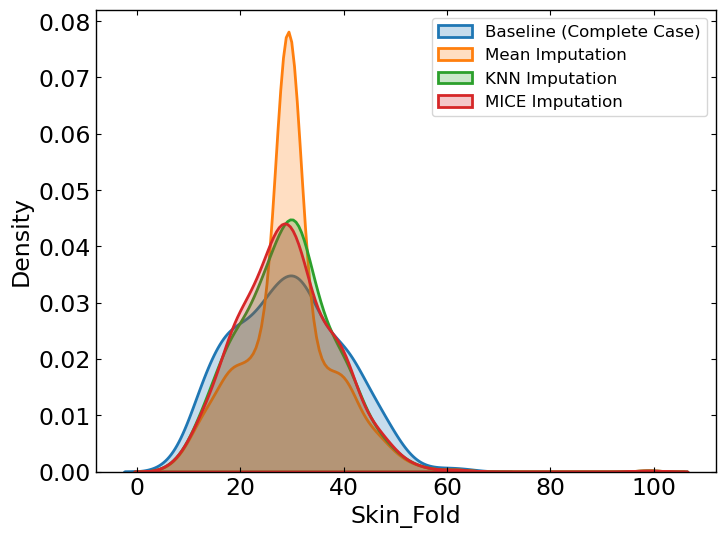

In [47]:
''' Plot graphs of imputed DataFrames and the complete case '''
fig, ax = plt.subplots()

sns.kdeplot(diabetes_cc.Skin_Fold, ax=ax, label='Baseline (Complete Case)', lw=2, shade=True)
sns.kdeplot(diabetes_mean.Skin_Fold, ax=ax, label='Mean Imputation', lw=2, shade=True)
sns.kdeplot(diabetes_knn_imputed.Skin_Fold, ax=ax, label='KNN Imputation', lw=2, shade=True)
sns.kdeplot(diabetes_mice_imputed.Skin_Fold, ax=ax, label='MICE Imputation', lw=2, shade=True)

ax.legend(fontsize=12);